In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shutil
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

In [11]:
# cutting into slices
import os
import re
from pydub import AudioSegment

# 创建 slice 文件夹（如果不存在）
output_folder = "test_slices"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 读取文件名中的数字
def get_file_number(filename):
    match = re.match(r"(\d+)\.wav", filename)
    return int(match.group(1)) if match else None

# 对文件进行重命名，使其按顺序排列
def rename_files_in_order(folder):
    files = os.listdir(folder)
    slice_files = [f for f in files if re.match(r"\d+\.wav", f)]
    slice_files.sort(key=lambda x: get_file_number(x))  # 按数字排序

    # 重命名文件，使其按顺序排列
    for i, filename in enumerate(slice_files):
        expected_filename = f"{i}.wav"
        current_path = os.path.join(folder, filename)
        expected_path = os.path.join(folder, expected_filename)
        if filename != expected_filename:
            os.rename(current_path, expected_path)

# 确保文件名有序
rename_files_in_order(output_folder)

# 获取当前最大编号
existing_files = os.listdir(output_folder)
slice_files = [f for f in existing_files if re.match(r"\d+\.wav", f)]
if slice_files:
    slice_files.sort(key=lambda x: get_file_number(x))  # 按数字排序
    start_index = get_file_number(slice_files[-1]) + 1  # 从最大编号的下一个开始
else:
    start_index = 0  # 如果没有文件，从0开始

# 读取 wav 文件
audio = AudioSegment.from_wav("1.wav")

# 切片长度（毫秒）
slice_length = 3000

# 切片并保存
for i in range(0, len(audio), slice_length):
    segment = audio[i:i + slice_length]
    # 导出到 slice 文件夹中，从 start_index 开始命名
    segment.export(os.path.join(output_folder, f"{start_index}.wav"), format="wav")
    start_index += 1


In [40]:
# have test folders
base_dir = '/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices'
folder_0 = os.path.join(base_dir, '0')
folder_1 = os.path.join(base_dir, '1')
folder_test = os.path.join(base_dir, 'test')
combined_folder = os.path.join(base_dir, 'combined')

def extract_number(filename):
    return int(filename.replace('slice_', '').split('.')[0])
    
if os.path.exists(combined_folder):
    shutil.rmtree(combined_folder)  # 删除文件夹及其内容
os.makedirs(combined_folder)  # 创建新的combined文件夹

# 获取0文件夹中的文件并重新排序
files_0 = sorted([f for f in os.listdir(folder_0) if f != '.DS_Store'], key=lambda x: int(os.path.splitext(x)[0]))


new_num = 0
for index,file_name in enumerate(files_0):
    old_file_path = os.path.join(folder_0, file_name)
    new_file_name = f"{new_num}.wav"  # 新的文件名
    new_file_path = os.path.join(folder_0, new_file_name)
    os.rename(old_file_path, new_file_path)
    shutil.copy(new_file_path, combined_folder) # 移动到combined文件夹
    new_num += 1


# 获取0文件夹中的最大序号
max_index = len(files_0)

# 获取1文件夹中的文件并重新命名
files_1 = sorted([f for f in os.listdir(folder_1) if f != '.DS_Store'], key=lambda x: int(os.path.splitext(x)[0]))

one_list = []
new_num2 = max_index
for index,file_name in enumerate(files_1):
    old_file_path = os.path.join(folder_1, file_name)
    new_file_name = f"{new_num2}.wav"  # 新的文件名
    new_file_path = os.path.join(folder_1, new_file_name)
    os.rename(old_file_path, new_file_path)
    shutil.copy(new_file_path, combined_folder)
    one_list.append(max_index + index)  # 记录新的序号
    new_num2+= 1

print(max_index)
print(len(files_1))

103
74


In [44]:
# random seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data.astype(type(data[0]))

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(len(data) * shift_max))
    return np.roll(data, shift)

def change_pitch(data, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

def stretch_audio(data, stretch_factor=0.8):
    return librosa.effects.time_stretch(data, rate=stretch_factor)


# Mel spectrum
# a frequency representation commonly used for audio classification
def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=None)
    if augment:
        y = add_noise(y)
        y = time_shift(y)
        y = change_pitch(y, sr)
        y = stretch_audio(y)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=256)

    # Delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)
    

    # Combine Mel Spectrogram and MFCC features
    combined_features = np.vstack((mel_spec_db, mfcc, delta_mfcc))

    # Normalize the combined features
    combined_features_norm = (combined_features - np.mean(combined_features)) / np.std(combined_features)

    # Padding or Trimming
    if combined_features_norm.shape[1] < 431:
        combined_features_norm = np.pad(combined_features_norm, ((0, 0), (0, 431 - combined_features_norm.shape[1])), mode='constant', constant_values=(0, 0))
    elif combined_features_norm.shape[1] > 431:
        combined_features_norm = combined_features_norm[:, :431]

    return combined_features_norm




def plot_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)  # 加载音频文件
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # 转换为分贝单位

    plt.figure(figsize=(10, 4))  # 设置图像大小
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')  # 显示频谱图
    plt.colorbar(format='%+2.0f dB')  # 显示颜色条
    plt.title('Mel-Spectrogram')  # 标题
    plt.tight_layout()  # 紧凑显示图像
    plt.show()
    
# prepare dataset for Mel
def prepare_dataset(file_paths, labels, augment=False):
    features = []
    valid_labels = []
    
    for file, label in zip(file_paths, labels):
        feature = extract_features(file, augment=augment)
       
        features.append(feature)
        valid_labels.append(label)
    
    # 根据实际的特征形状调整reshape的参数
    features = np.array(features)  # 假设特征形状已经是正确的，无需reshape
    return features, np.array(valid_labels)
    # features = []
    # valid_labels = []
    
    # for file, label in zip(file_paths, labels):
    #     feature = extract_features(file, augment=augment)
    #     print("Feature shape:", feature.shape)
        
    #     if feature.shape[1] < 431:
    #         padded_feature = np.pad(feature, ((0, 0), (0, 431 - feature.shape[1])), mode='constant')
    #     else:
    #         padded_feature = feature[:, :431]
    #     features.append(padded_feature)
    #     valid_labels.append(label)
    #     print(f"处理文件 {file}，分配的标签为 {label}")
  
    
    # features = np.array(features).reshape(-1, 128, 431, 1)
    # return features, np.array(valid_labels)
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(154, 431, 1)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),  # Increased dropout ratio
        
        Conv2D(64, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Flatten(),
        
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Increased L2 regularization
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# def build_model():
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(154, 431, 1)),
#         MaxPooling2D(2, 2),
#         Dropout(0.2),
        
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D(2, 2),
#         Dropout(0.2),

#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D(2, 2),
#         Dropout(0.2),

#         # 新增的卷积层
#         Conv2D(256, (3, 3), activation='relu'),
#         MaxPooling2D(2, 2),
#         BatchNormalization(),  # 添加批量归一化
#         Dropout(0.3),  # 增加 Dropout 比率以防过拟合

#         Flatten(),
        
#         # 全连接层
#         Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
#         Dropout(0.3),
        
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#     return model
# 生成文件路径和标签
file_paths = [f'/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices/combined/{i}.wav' for i in range(max_index + len(files_1))]

labels = [0] * (max_index + len(files_1))
for i in one_list:
    labels[i] = 1
print(labels)

# 准备数据
X, y = prepare_dataset(file_paths, labels)  # 使用数据增强
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# 创建并训练模型
model = build_model()

# 调整类权重，增加0类的权重
# 修改为更均衡的类权重
class_weight_dict = {0: 1.0, 1: 1.0}


# 使用 EarlyStopping 和 ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

# evaluation
model.evaluate(X_test, y_test)

# 保存模型


# 使用模型进行预测，并调整阈值
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
# 加载模型


model.save('guzhengtest.h5')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Epoch 1/100


2024-11-17 16:27:34.200850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 13.9864 - accuracy: 0.4151

2024-11-17 16:27:42.952431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 10s 1s/step - loss: 13.9864 - accuracy: 0.4151 - val_loss: 3.2483 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 2s 415ms/step - loss: 5.4503 - accuracy: 0.6038 - val_loss: 3.2229 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 3/100
5/5 [==============================] - 2s 408ms/step - loss: 3.4587 - accuracy: 0.6352 - val_loss: 3.1727 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/100
5/5 [==============================] - 2s 406ms/step - loss: 3.5083 - accuracy: 0.6164 - val_loss: 3.1672 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 5/100
5/5 [==============================] - 2s 386ms/step - loss: 3.2021 - accuracy: 0.7107 - val_loss: 3.1451 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 6/100
5/5 [==============================] - 2s 444ms/step - loss: 2.8457 - accuracy: 0.7925 - val_loss: 3.0936 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 7/100
5/5 [==============================] - 2s 512ms/step 

/Users/zhuxinyuan/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 154, 431, 32)      320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 154, 431, 32)      0         
                                                                 
 batch_normalization_3 (Bat  (None, 154, 431, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 77, 215, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 77, 215, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 215, 64)      

In [43]:
model = load_model('guzhengtest.h5')

def predict_pizzicato(file_path, threshold=0.5):
    feature = extract_features(file_path)  # 确保这里提取的特征是正确的尺寸

    # 确保特征形状正确
    if feature.shape[0] != 154 or feature.shape[1] != 431:
        # 如果维度不匹配，则填充或裁剪到正确尺寸
        # 填充到 (154, 431)
        if feature.shape[0] < 154:
            feature = np.pad(feature, ((0, 154 - feature.shape[0]), (0, 0)), 'constant', constant_values=(0, 0))
        elif feature.shape[0] > 154:
            feature = feature[:154, :]

        if feature.shape[1] < 431:
            feature = np.pad(feature, ((0, 0), (0, 431 - feature.shape[1])), 'constant', constant_values=(0, 0))
        elif feature.shape[1] > 431:
            feature = feature[:, :431]

    # 重塑为模型的输入形状 (1, 154, 431, 1)
    padded_feature = feature.reshape(1, 154, 431, 1)
    prediction = model.predict(padded_feature)

    print(f"prediction rate: {prediction[0][0]}")

    return prediction[0][0]

answers = [] 
predicted_probs = [] 
test_folder = '/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices/test'
test_file_paths = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if file.endswith('.wav')]
predictions = []
i = 0
for file_path in test_file_paths:
    file_name = os.path.basename(file_path)
    label = 1 if file_name.startswith('1') else 0  # 假设文件名以'1'开始的为正类
    answers.append(label)
    prob = predict_pizzicato(file_path)
    predicted_probs.append(prob)
    print(f'{file_name}: {prob:.4f} (label: {label})')

# 评估不同阈值
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_accuracy = 0

for threshold in thresholds:
    predictions = [1 if p >= threshold else 0 for p in predicted_probs]
    accuracy = accuracy_score(answers, predictions)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best Accuracy: {best_accuracy:.4%}')

manual_threshold = 0.2  # 你可以根据需要修改这个阈值

# 使用手动阈值进行预测
manual_predictions = [1 if p >= manual_threshold else 0 for p in predicted_probs]
manual_accuracy = accuracy_score(answers, manual_predictions)

# 打印结果
print(f"Using manual threshold of {manual_threshold}, the accuracy is: {manual_accuracy:.4%}")


1/1 [==============================] - 0s 89ms/step
prediction rate: 0.14571015536785126
0_slice_103.wav: 0.1457 (label: 0)
1/1 [==============================] - 0s 16ms/step
prediction rate: 0.0905672162771225
0_slice_105.wav: 0.0906 (label: 0)
1/1 [==============================] - 0s 11ms/step


2024-11-17 15:54:58.281251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


prediction rate: 0.08311942219734192
0_slice_110.wav: 0.0831 (label: 0)
1/1 [==============================] - 0s 12ms/step
prediction rate: 0.10952432453632355
0_slice_104.wav: 0.1095 (label: 0)
1/1 [==============================] - 0s 19ms/step
prediction rate: 0.17799995839595795
0_slice_106.wav: 0.1780 (label: 0)
1/1 [==============================] - 0s 11ms/step
prediction rate: 0.061521779745817184
0_slice_107.wav: 0.0615 (label: 0)
1/1 [==============================] - 0s 13ms/step
prediction rate: 0.5200178623199463
1_slice_146.wav: 0.5200 (label: 1)
1/1 [==============================] - 0s 16ms/step
prediction rate: 0.4195876717567444
1_slice_147.wav: 0.4196 (label: 1)
1/1 [==============================] - 0s 14ms/step
prediction rate: 0.504957377910614
1_slice_145.wav: 0.5050 (label: 1)
1/1 [==============================] - 0s 13ms/step
prediction rate: 0.46924880146980286
1_slice_150.wav: 0.4692 (label: 1)
1/1 [==============================] - 0s 11ms/step
prediction 

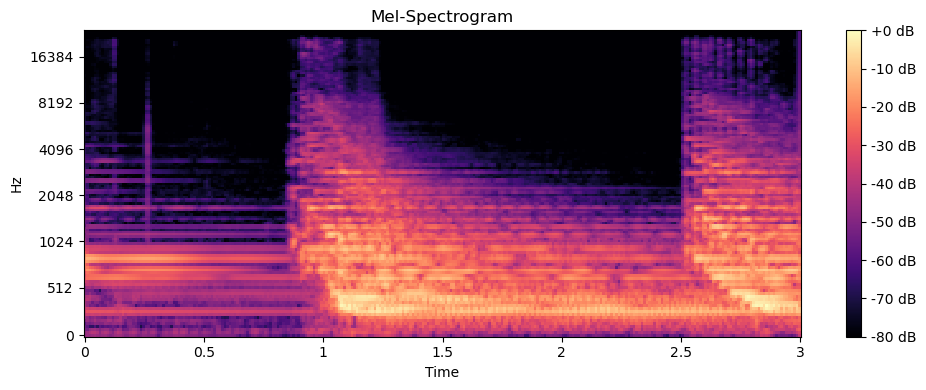

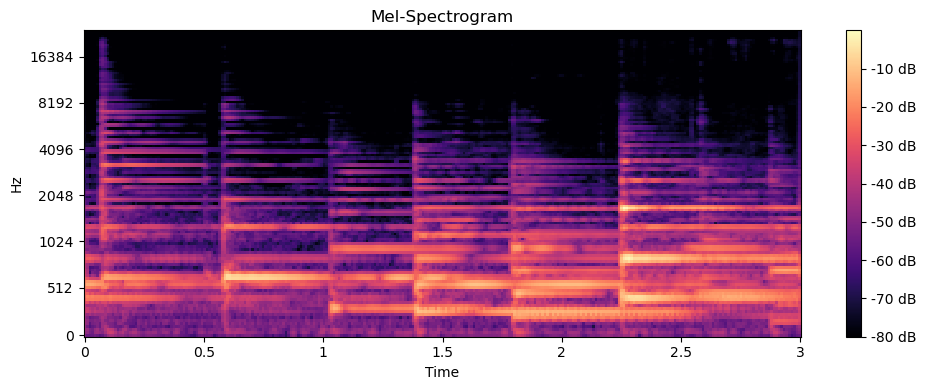

In [49]:
plot_mel_spectrogram('/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices/1/103.wav')
plot_mel_spectrogram('/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices/0/2.wav')

1/1 [==============================] - 0s 244ms/step


2024-11-23 21:50:55.356194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


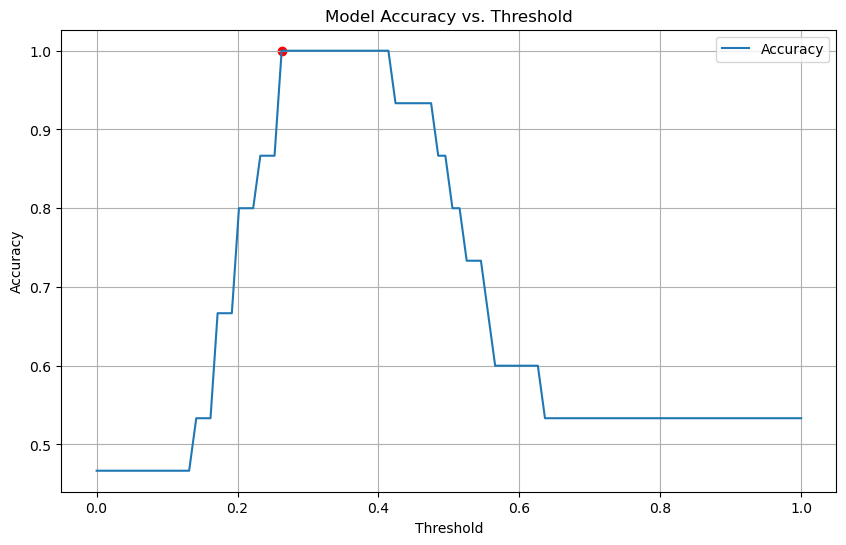

Best Threshold: 0.2626
Best Accuracy: 100.0000%


In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Assuming your 'extract_features' and other related functions are defined above this script

# Load the pre-trained model
model = load_model('guzhengtest.h5')

def predict_pizzicato(file_path, model, threshold=0.5):
    feature = extract_features(file_path)  # Extract features with correct dimensions

    # Ensure feature shape is correct
    if feature.shape != (154, 431):
        feature = np.pad(feature, [(0, 154 - feature.shape[0]), (0, 431 - feature.shape[1])], mode='constant', constant_values=0)
    
    # Reshape for model input
    feature = feature.reshape(1, 154, 431, 1)
    prediction = model.predict(feature)
    return prediction[0][0]

def evaluate_model(test_folder, model):
    test_file_paths = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if file.endswith('.wav')]
    answers, predicted_probs = [], []

    for file_path in test_file_paths:
        file_name = os.path.basename(file_path)
        label = 1 if file_name.startswith('1') else 0
        answers.append(label)
        prob = predict_pizzicato(file_path, model)
        predicted_probs.append(prob)

    thresholds = np.linspace(0, 1, 100)
    accuracies = []

    for threshold in thresholds:
        predictions = [1 if p >= threshold else 0 for p in predicted_probs]
        accuracy = accuracy_score(answers, predictions)
        accuracies.append(accuracy)

    best_threshold = thresholds[np.argmax(accuracies)]
    best_accuracy = np.max(accuracies)

    # Plotting the accuracy vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.scatter([best_threshold], [best_accuracy], color='red')  # Highlight the best threshold
    plt.title('Model Accuracy vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_accuracy

# Usage
test_folder = '/Users/zhuxinyuan/tensorflow-test/mine/1-Guzheng/test_slices/test'
best_threshold, best_accuracy = evaluate_model(test_folder, model)
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Accuracy: {best_accuracy:.4%}")
